[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luisar/stock-forecasting-lstm/blob/main/LSTM_Forecasting.ipynb) 

# Forecasting with LSTM Test

Just to practice LSTM with a real-life usage. None of this is valid information or advice for trading.

# Data

The dataset to be used is a download from https://finance.yahoo.com/quote/TSLA/history/ with a "Max" filter in the "Time Period".

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "path/to/file"

In [55]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from copy import deepcopy

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [5]:
df = pd.read_csv(path + 'TSLA.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400
2955,2022-03-24,1009.729980,1024.489990,988.799988,1013.919983,1013.919983,22973600
2956,2022-03-25,1008.000000,1021.799988,997.320007,1010.640015,1010.640015,20642900


In [6]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2953,2022-03-22,993.979980
2954,2022-03-23,999.109985
2955,2022-03-24,1013.919983
2956,2022-03-25,1010.640015


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

df['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
2953   2022-03-22
2954   2022-03-23
2955   2022-03-24
2956   2022-03-25
2957   2022-03-25
Name: Date, Length: 2958, dtype: datetime64[ns]

# Index

In order to manipulate better, change the index that's currently available for the Date values.

In [11]:
df.index = df.pop('Date')
df

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-22,993.979980
2022-03-23,999.109985
2022-03-24,1013.919983


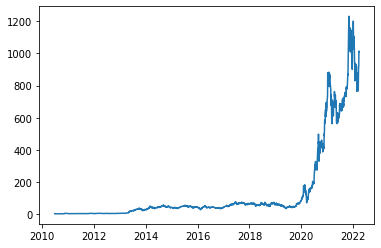

In [12]:
plt.plot(df.index, df['Close'])

In [39]:
# This code was found on a repo online, sadly I lost the URL and can't find it again. If I do I will update.
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = pd.to_datetime(first_date_str)
  last_date  = pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

#'2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2020-12-31	', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-12-31,663.690002,665.989990,694.780029,705.669983
1,2021-01-04,665.989990,694.780029,705.669983,729.770020
2,2021-01-05,694.780029,705.669983,729.770020,735.109985
3,2021-01-06,705.669983,729.770020,735.109985,755.979980
4,2021-01-07,729.770020,735.109985,755.979980,816.039978
...,...,...,...,...,...
304,2022-03-17,766.369995,801.890015,840.229980,871.599976
305,2022-03-18,801.890015,840.229980,871.599976,905.390015
306,2022-03-21,840.229980,871.599976,905.390015,921.159973
307,2022-03-22,871.599976,905.390015,921.159973,993.979980


In [40]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((309,), (309, 3, 1), (309,))

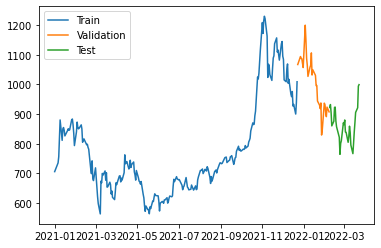

In [41]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] #from beginning to 80%

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] #between 80 and 90%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] #from 90% to 100%

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [49]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

Epoch 1/200
8/8 [==============================] - 6s 83ms/step - loss: 620190.6875 - mean_absolute_error: 771.9869 - val_loss: 1021031.5625 - val_mean_absolute_error: 1006.4836
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 619437.9375 - mean_absolute_error: 771.4999 - val_loss: 1020020.6875 - val_mean_absolute_error: 1005.9809
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 618481.6250 - mean_absolute_error: 770.8778 - val_loss: 1018402.1250 - val_mean_absolute_error: 1005.1766
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 617188.3750 - mean_absolute_error: 770.0368 - val_loss: 1016587.5000 - val_mean_absolute_error: 1004.2733
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 615480.1875 - mean_absolute_error: 768.9295 - val_loss: 1013822.4375 - val_mean_absolute_error: 1002.8959
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 613292.5625 - mean_absolute_error: 767.4918

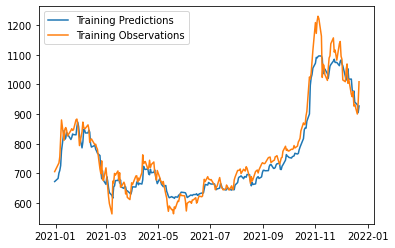

In [50]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

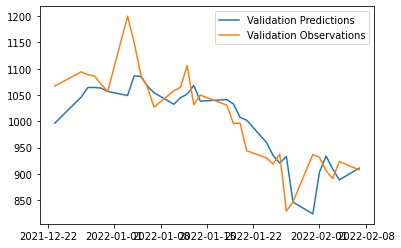

In [51]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

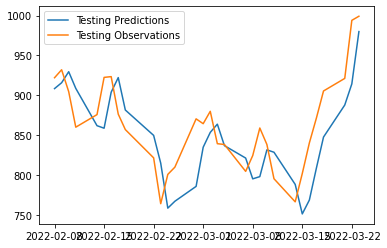

In [52]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

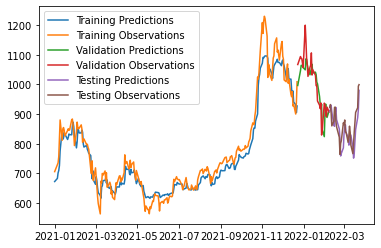

In [53]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [56]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

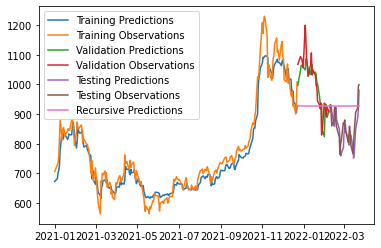

In [57]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

# Conclusion

LSTM is probably not the best choice for forecasting. In general, if I reduce the data points it would improve the extrapolation of the model. 

That being said, it can be seen, in this last chart that the prediction flattens which makes it likely that further refinements have to be done to improve the prediction.